# Cassandra driver.

Query Cassandra database to get activations for pages stored in JSON graph.

In [1]:
from cassandra.cluster import Cluster
from cassandra.cluster import ExecutionProfile
from cassandra.auth import PlainTextAuthProvider
from cassandra import query
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import json

In [2]:
plt.style.use('seaborn-colorblind')
from pylab import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['xtick.labelsize'] = 25
rcParams['ytick.labelsize'] = 25
rcParams['axes.labelsize'] = 35
rcParams['legend.fontsize'] = 25

Read ids from JSON graph

In [5]:
with open('./data/final/2018-11-1q.json') as json_file:  
    data = json.load(json_file)
pages = data['nodes']

In [6]:
page_id_title_dict = {}

for page in pages:
    page_id_title_dict[int(page['id'])] = page['label'].replace('_',' ')

In [7]:
print("Number of nodes: ", len(tuple(page_id_title_dict.keys())))

Number of nodes:  5207


Prepare Cassandra connection

In [8]:
import configparser
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [10]:
auth_provider = PlainTextAuthProvider(
        username=config['cassandraDB']['user'], password=config['cassandraDB']['pass'])
# execution_profile = ExecutionProfile(request_timeout=3600, row_factory=pandas_factory)
# profiles = {'node1': execution_profile}

In [11]:
cluster = Cluster([config['cassandraDB']['host']], auth_provider=auth_provider, port=9042)

In [12]:
session = cluster.connect()

In [13]:
session.default_timeout = 3600

In [14]:
session.set_keyspace("wikipedia")

In [15]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

In [16]:
session.row_factory = pandas_factory

In [17]:
session.default_fetch_size = 10000000 #needed for large queries, otherwise driver will do pagination. Default is 50000.

Query Cassandra

In [18]:
session.execute("SELECT * FROM wikipedia.pagecount_metadata")._current_rows.head()

,start_time,end_time
0,2018-07-01,2019-01-01


In [38]:
# page_id_title_dict = {20966: "Marvel Comics", 9105: "DC Comics"}

In [77]:
start_time = "2018-11-01 00:00:00"
end_time = "2018-11-15 00:00:00"
ids_list_string = str(tuple(page_id_title_dict.keys()))

In [78]:
#NOTE: this query is time-consuming. Update cassandra.yaml `read_request_timeout_in_ms` to 50000 ms and `range_request_timeout_in_ms` to 10000
rows = session.execute("SELECT * FROM wikipedia.page_visits WHERE page_id IN " + ids_list_string + " AND visit_time >='" + start_time + "' AND visit_time <='" + end_time + "'")

In [79]:
rows_df = rows._current_rows

In [80]:
rows_df.shape

(1203808, 3)

Save the query result

In [81]:
rows_df.to_pickle('./data/activations_cassandra_nov_1q.pickle')

In [82]:
# rows_df.replace({'page_id': page_id_title_dict}, inplace=True)
rows_df.head()

,page_id,visit_time,count
0,791,2018-10-31 23:00:00,16
1,791,2018-11-01 00:00:00,23
2,791,2018-11-01 01:00:00,12
3,791,2018-11-01 02:00:00,32
4,791,2018-11-01 03:00:00,14


Groupby to plot

In [83]:
rows_df.set_index('visit_time', inplace=True)
# rows_df = rows_df.groupby('page_id')
rows_df = rows_df.loc[rows_df['page_id'] == 791].groupby('page_id')

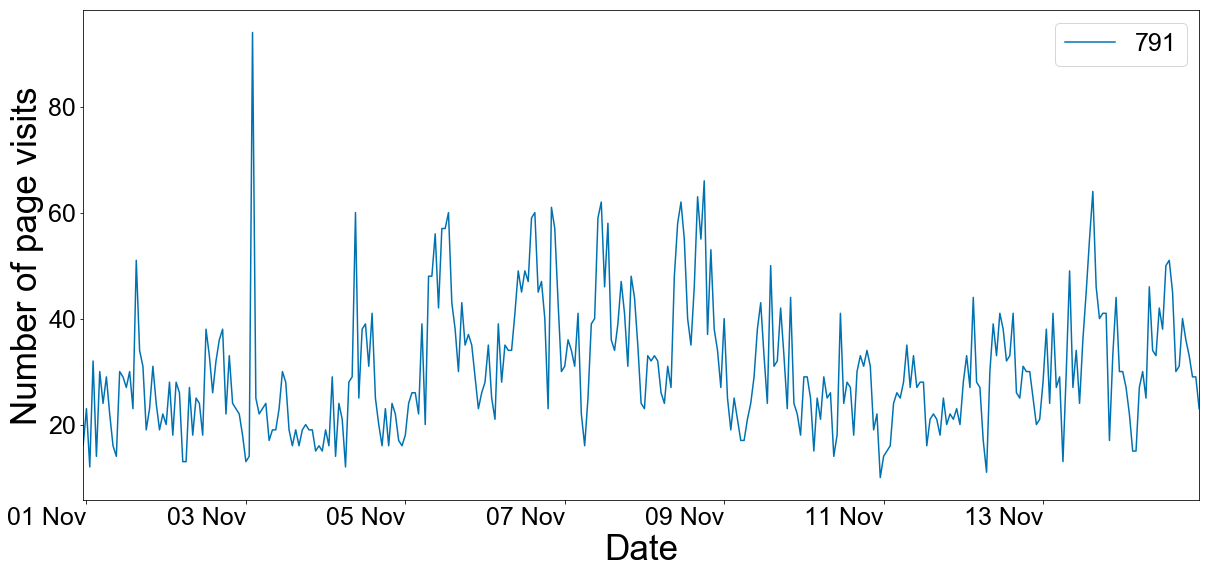

In [84]:
fig, ax = plt.subplots(figsize = (20,10))
rows_df['count'].plot(legend=True, x_compat=True)
plt.xlabel("Date")
plt.ylabel("Number of page visits")
plt.setp(ax.get_xticklabels(), rotation=0)
ax.xaxis.set_major_formatter(
    mdates.DateFormatter('%d %b')
)
# plt.savefig("timeseries.pdf", format="PDF", bbox_inches='tight')